In [1]:
import sys
import os
import matplotlib.pyplot as plt

RANDOM_SEED = 43

TRAINING_RESUME = False
RESUME_EPOCH = 12
MODEL_SAVE_PATH = 'model/'
RAW_DATA_PATH = 'corpus_hw211.txt'
TEST_DATA_PATH = 'hw2.1-1_testing_data.txt'

RESET_AND_TRAIN = False ###### Warning (If you only want to predict on test, you must turn this off (False)) ######
COLLECT_WORDS = RESET_AND_TRAIN
TRAIN_WORD2VEC = RESET_AND_TRAIN
EMBEDDING_REBUILD = RESET_AND_TRAIN

WORD2VEC_DIMENSION = 128

LEARNING_RATE =  1e-3
BATCH_SIZE = 1024
MAX_EPOCH = 50
INIT_GRU = True

ENCODER_OUTPUT_SIZE = WORD2VEC_DIMENSION
DECODER_HIDDEN_SIZE = ENCODER_OUTPUT_SIZE
TEACHER_FORCING_RATIO = 0.5
GRU_NUM_LAYERS = 4
GRU_DROPOUT_RATE = 0
EMBEDDING_DROPOUT_RATE = 0

# for logging
CHECKPOINT_NAME = 'auto_encoder.pt'

# %% [markdown]
# # Seq2Seq
# %% [markdown]
# ## Prepare data
# %% [markdown]
# ### Set Random seed

In [2]:
import torch
torch.manual_seed(RANDOM_SEED)

# %% [markdown]
# ## Training data
# %% [markdown]
# ### Read training data
# %% [markdown]
# Currently, we only use "train.txt" to train, validate and test our Seq2Seq model.

In [3]:
import pandas as pd
import numpy as np

def read_dataset(path):
    
    with open(path, 'r', encoding= 'utf-8') as f:
        data = []
        i = 0
        lines = f.readlines()
        for i, line in enumerate(lines):

            # Doing nothing, just insert directly.
            sentence = line.strip()
            if i > len(lines) - 2:
                label = '<SOS> <EOS>'
            else:
                label = lines[i+1]
                eos_pos = label.rfind('<EOS>')
                label = label[:eos_pos+5].strip()

            data.append([sentence, label])

        dataset = pd.DataFrame(data, columns = ['Sentence', 'Label'])

        f.close()
    
    return dataset


In [4]:
dataset = read_dataset(path=RAW_DATA_PATH)


In [5]:
print ('# Train + Valid Data:', len(dataset))


# Train + Valid Data: 739868


In [6]:
dataset.head()

# %% [markdown]
# ### Analyze the data length (only sentence)

,Sentence,Label
0,<SOS> 心 疼 你 还 没 挣 脱 思 念 的 囚 禁 <EOS> 9 行,<SOS> 他 在 你 一 段 难 忘 远 行 最 后 却 离 去 <EOS>
1,<SOS> 他 在 你 一 段 难 忘 远 行 最 后 却 离 去 <EOS> 8 这,<SOS> 你 无 力 依 靠 在 我 这 里 <EOS>
2,<SOS> 你 无 力 依 靠 在 我 这 里 <EOS> 9 玻,<SOS> 隔 着 刚 被 雨 淋 湿 的 玻 璃 <EOS>
3,<SOS> 隔 着 刚 被 雨 淋 湿 的 玻 璃 <EOS> 1 你,<SOS> 你 问 了 我 到 底 爱 在 哪 里 <EOS>
4,<SOS> 你 问 了 我 到 底 爱 在 哪 里 <EOS> 3 想,<SOS> 你 最 想 去 的 目 的 地 剩 多 少 公 里 <EOS>


In [7]:
def split_sentence(sent):
    sent = sent.lower()
    new_sent = sent.split(' ')
    return new_sent


In [8]:
trimmed_sents = dataset['Sentence'].map(split_sentence)
print (trimmed_sents[:5])


0    [<sos>, 心, 疼, 你, 还, 没, 挣, 脱, 思, 念, 的, 囚, 禁, <e...
1    [<sos>, 他, 在, 你, 一, 段, 难, 忘, 远, 行, 最, 后, 却, 离,...
2      [<sos>, 你, 无, 力, 依, 靠, 在, 我, 这, 里, <eos>, 9, 玻]
3    [<sos>, 隔, 着, 刚, 被, 雨, 淋, 湿, 的, 玻, 璃, <eos>, 1...
4    [<sos>, 你, 问, 了, 我, 到, 底, 爱, 在, 哪, 里, <eos>, 3...
Name: Sentence, dtype: object


Maximum sentence length: 28


Text(0.5, 1.0, 'Length Analysis')

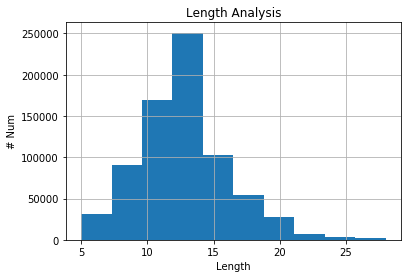

In [9]:
sent_lens = trimmed_sents.map(len)
max_sent_len = sent_lens.max()
print ('Maximum sentence length:', max_sent_len)
sent_lens.hist()
plt.ylabel('# Num')
plt.xlabel('Length')
plt.title('Length Analysis')

# %% [markdown]
# ## Testing data
# %% [markdown]
# ### Read testing data

In [10]:
testset = read_dataset(path=TEST_DATA_PATH)


In [11]:
testset.head()


,Sentence,Label
0,<SOS> 在 我 们 心 中 慢 慢 流 动 的 温 柔 <EOS> 2 于,<SOS> 如 梦 如 幻 的 游 戏 <EOS>
1,<SOS> 如 梦 如 幻 的 游 戏 <EOS> 9 法,<SOS> 街 角 有 人 祝 福 <EOS>
2,<SOS> 街 角 有 人 祝 福 <EOS> 4 个,<SOS> 平 凡 狼 爱 平 凡 的 活 <EOS>
3,<SOS> 平 凡 狼 爱 平 凡 的 活 <EOS> 6 肩,<SOS> 友 情 是 最 不 吝 啬 <EOS>
4,<SOS> 友 情 是 最 不 吝 啬 <EOS> 12 脸,<SOS> 八 百 里 秦 川 <EOS>


In [12]:
print ('# Test Data:', len(testset))


# Test Data: 50000


In [13]:
trimmed_sents = testset['Sentence'].map(split_sentence)
print (trimmed_sents[:5])


0    [<sos>, 在, 我, 们, 心, 中, 慢, 慢, 流, 动, 的, 温, 柔, <e...
1            [<sos>, 如, 梦, 如, 幻, 的, 游, 戏, <eos>, 9, 法]
2               [<sos>, 街, 角, 有, 人, 祝, 福, <eos>, 4, 个]
3         [<sos>, 平, 凡, 狼, 爱, 平, 凡, 的, 活, <eos>, 6, 肩]
4           [<sos>, 友, 情, 是, 最, 不, 吝, 啬, <eos>, 12, 脸]
Name: Sentence, dtype: object


Maximum sentence length: 19


Text(0.5, 1.0, 'Length Analysis')

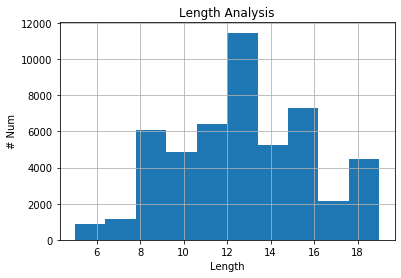

In [14]:
sent_lens = trimmed_sents.map(len)
max_sent_len = sent_lens.max()
print ('Maximum sentence length:', max_sent_len)
sent_lens.hist()
plt.ylabel('# Num')
plt.xlabel('Length')
plt.title('Length Analysis')

# %% [markdown]
# ## Training word2vec embedding

In [15]:
from gensim.models import Word2Vec

splitted_sents =  dataset['Sentence'] .map(split_sentence)
splitted_sents = splitted_sents.values.tolist()
print (splitted_sents[:5])

if os.path.isfile('./w2v.model') and not TRAIN_WORD2VEC:
    print ('Loading trained embedding now...')
    w2v_model = Word2Vec.load('./w2v.model')
else:
    print ('Training new embedding now...')
    w2v_model = Word2Vec(splitted_sents, size=WORD2VEC_DIMENSION, workers=4, iter=5, min_count=1)
    w2v_model.save('w2v.model')

# %% [markdown]
# ### Split into trainset and testset
# %% [markdown]
# train : valid : test = 3 : 1 : 1

[['<sos>', '心', '疼', '你', '还', '没', '挣', '脱', '思', '念', '的', '囚', '禁', '<eos>', '9', '行'], ['<sos>', '他', '在', '你', '一', '段', '难', '忘', '远', '行', '最', '后', '却', '离', '去', '<eos>', '8', '这'], ['<sos>', '你', '无', '力', '依', '靠', '在', '我', '这', '里', '<eos>', '9', '玻'], ['<sos>', '隔', '着', '刚', '被', '雨', '淋', '湿', '的', '玻', '璃', '<eos>', '1', '你'], ['<sos>', '你', '问', '了', '我', '到', '底', '爱', '在', '哪', '里', '<eos>', '3', '想']]
Loading trained embedding now...


In [16]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

trainset, validset = train_test_split(dataset, test_size=0.3, random_state=42)
# trainset, validset = train_test_split(trainset, test_size=0.25, random_state=42)

trainset.to_csv('trainset.csv', index=False)
validset.to_csv('validset.csv', index=False)
testset.to_csv('testset.csv', index=False)


In [17]:
print ('trainset:', len(trainset))
print ('validset:', len(validset))
print ('testset:', len(testset))

# %% [markdown]
# ### Collect words

trainset: 517907
validset: 221961
testset: 50000


In [18]:
from multiprocessing import Pool
from nltk.tokenize import word_tokenize

def collect_words(data_path, n_workers=4):
    df = pd.read_csv(data_path, dtype=str)
        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Sentence'].lower().split(' ')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(word_tokenize, chunks)
        words = set(sum(chunks.get(), []))

    return words


In [19]:
def make_up_word_dictionary(words, init_dict):
    
    ### Remove the redundant tokens
    redundant_tokens = ['<', '>', 'sos', 'eos']
    for token in redundant_tokens:
        if token in words:
            words.remove(token)
    
    ### Make up word dictionary
    word_dict = init_dict

    for word in words:
        word_dict[word]=len(word_dict)
        
    return word_dict


In [20]:
import pickle
    
PAD_TOKEN = 0
UNK_TOKEN = 1
SOS_TOKEN = 2
EOS_TOKEN = 3
init_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN,'<sos>':SOS_TOKEN,'<eos>':EOS_TOKEN}

# Collect words from training set
words = set()
words |= collect_words('trainset.csv')
    
if os.path.isfile('./dicitonary.pkl') and not COLLECT_WORDS:
    print ('Loading collected word dictionary now...')
    with open('dicitonary.pkl','rb') as f:
        word_dict = pickle.load(f)
        f.close()
else:
    print ('Collecting new word dictionary now...')
    word_dict = make_up_word_dictionary(words=words, init_dict=init_dict)
    
    with open('dicitonary.pkl','wb') as f:
        pickle.dump(word_dict, f)
        f.close()


Loading collected word dictionary now...


In [21]:
print ('# num words:', len(word_dict))

# %% [markdown]
# ## Embedding class to save pretrained embedding

# num words: 6330


In [22]:
import re
import torch
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class Embedding:
    """
    Args:
        embedding_path (str): Path where embedding are loaded from (text file).
        words (None or list): If not None, only load embedding of the words in
            the list.
        oov_as_unk (bool): If argument `words` are provided, whether or not
            treat words in `words` but not in embedding file as `<unk>`. If
            true, OOV will be mapped to the index of `<unk>`. Otherwise,
            embedding of those OOV will be randomly initialize and their
            indices will be after non-OOV.
        lower (bool): Whether or not lower the words.
        rand_seed (int): Random seed for embedding initialization.
    """

    def __init__(self, embedding_path=None,
                 words=None, oov_as_unk=True, lower=True, rand_seed=524):
        self.word_dict = {}
        self.index_dict = {}
        self.vectors = None
        self.lower = lower
        
        self.extend(embedding_path, words, oov_as_unk)
        torch.manual_seed(rand_seed)

        if '<pad>' not in self.word_dict:
            self.add(
                '<pad>', torch.zeros(self.get_dim())
            )
        
        if '<sos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<sos>', t_tensor
            )
            
        if '<eos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<eos>', t_tensor
            )
        
        if '<unk>' not in self.word_dict:
            self.add('<unk>')

    def to_word(self, index):
        return self.index_dict[index]
    
    def to_index(self, word):
        """
        Args:
            word (str)

        Return:
             index of the word. If the word is not in `words` and not in the
             embedding file, then index of `<unk>` will be returned.
        """
        if self.lower:
            word = word.lower()

        if word not in self.word_dict:
            return self.word_dict['<unk>']
        else:
            return self.word_dict[word]

    def get_dim(self):
        return self.vectors.shape[1]

    def get_vocabulary_size(self):
        return self.vectors.shape[0]

    def add(self, word, vector=None):
        if self.lower:
            word = word.lower()

        if vector is not None:
            vector = vector.view(1, -1)
        else:
            vector = torch.empty(1, self.get_dim())
            torch.nn.init.uniform_(vector)
            
        self.vectors = torch.cat([self.vectors, vector], 0)
        self.index_dict[len(self.word_dict)] = word
        self.word_dict[word] = len(self.word_dict)

    def extend(self, embedding_path, words, oov_as_unk=True):
        
        if embedding_path is None:
            self._load_w2v_embedding(words)
            # self._one_hot_encoding(words) # One-hot encoding version (It can't well-trained)
        else:
            self._load_embedding(embedding_path, words)

        if words is not None and not oov_as_unk:
            # initialize word vector for OOV
            for word in words:
                if self.lower:
                    word = word.lower()

                if word not in self.word_dict:
                    self.index_dict[len(self.word_dict)] = word
                    self.word_dict[word] = len(self.word_dict)

            oov_vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict) - self.vectors.shape[0],
                            self.vectors.shape[1]))

            self.vectors = torch.cat([self.vectors, oov_vectors], 0)
    def _load_w2v_embedding(self, words):
        
        vectors = []
        
        for word in words:
            
            vector = w2v_model[word]
            
            # skip word not in words if words are provided
            if words is not None and word not in words:
                continue
            elif word not in self.word_dict:
                self.index_dict[len(self.word_dict)] = word
                self.word_dict[word] = len(self.word_dict)
                vectors.append([float(v) for v in vector])

        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors
        
    def _one_hot_encoding(self, words):

        vectors = []

        data_le = pd.DataFrame(words, columns=['Word'])
        data_dum = pd.get_dummies(data_le)
        
        for col in data_dum.columns:
            word = col[5:]
            self.index_dict[len(self.word_dict)] = word
            self.word_dict[word] = len(self.word_dict)
            vectors.append([float(row) for row in data_dum[col]])
        
        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors

    def _load_embedding(self, embedding_path, words):
        if words is not None:
            words = set(words)

        vectors = []

        with open(embedding_path) as fp:

            row1 = fp.readline()
            # if the first row is not header
            if not re.match('^[0-9]+ [0-9]+$', row1):
                # seek to 0
                fp.seek(0)
            # otherwise ignore the header

            for i, line in enumerate(fp):
                cols = line.rstrip().split(' ')
                word = cols[0]

                # skip word not in words if words are provided
                if words is not None and word not in words:
                    continue
                elif word not in self.word_dict:
                    self.index_dict[len(self.word_dict)] = word
                    self.word_dict[word] = len(self.word_dict)
                    vectors.append([float(v) for v in cols[1:]])

        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors


In [23]:
if os.path.isfile('./embedding.pkl') and not EMBEDDING_REBUILD:
    with open('embedding.pkl','rb') as f:
        embedder = pickle.load(f)
        f.close()
else:
    embedder = Embedding(words=words) 
    
    with open('embedding.pkl','wb') as f:
        pickle.dump(embedder, f)
        f.close()


In [24]:
max_key_len = max(len(key) for key in embedder.word_dict.keys())
print ('max lenght of key', max_key_len)
print ('')
print ('Embedder word dictionary:')
for key in embedder.word_dict.keys():
    padding = max_key_len - len(key)
    key_display = key + ' ' * padding
    print (key_display, embedder.word_dict[key])
    
    if embedder.word_dict[key] > 30:
        break


max lenght of key 5

Embedder word dictionary:
荔     0
鲈     1
懐     2
谇     3
娶     4
叟     5
寺     6
良     7
梶     8
舱     9
楨     10
緾     11
尚     12
叱     13
概     14
逊     15
雲     16
滾     17
順     18
媳     19
駐     20
谧     21
鱿     22
兖     23
蕖     24
閉     25
颖     26
衾     27
霉     28
價     29
谄     30
扯     31


In [25]:
print ('Embedder index dictionary:')
for key in embedder.index_dict.keys():

    print (key, ' ', embedder.index_dict[key])
    
    if key > 30:
        break


Embedder index dictionary:
0   荔
1   鲈
2   懐
3   谇
4   娶
5   叟
6   寺
7   良
8   梶
9   舱
10   楨
11   緾
12   尚
13   叱
14   概
15   逊
16   雲
17   滾
18   順
19   媳
20   駐
21   谧
22   鱿
23   兖
24   蕖
25   閉
26   颖
27   衾
28   霉
29   價
30   谄
31   扯


In [26]:
from tqdm import tqdm_notebook as tqdm
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
        We first tokenize the sentence and convert each word into indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [word_dict.to_index(word) for word in sentence.split(' ')]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['Sentence'] = sentence_to_indices(data['Sentence'], word_dict)
    processed['Label'] = sentence_to_indices(data['Label'], word_dict)
    
    return processed


In [27]:
print('[INFO] Start processing trainset...')
train = get_dataset('trainset.csv', embedder, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('validset.csv', embedder, n_workers=4)

# %% [markdown]
# ### Preserve the testset order 

[INFO] Start processing trainset...




[INFO] Start processing validset...






In [28]:
def get_dataset_with_no_multiprocessing(data_path, word_dict):
    
    dataset = pd.read_csv(data_path, dtype=str)
    trange = tqdm(dataset.iterrows(), total=len(dataset))
    
    processed = []
    
    for i, (sample) in enumerate(trange):
        processed.append(preprocess_sample(sample[1], word_dict))
        
    return processed


In [29]:
print('[INFO] Start processing testset...')
test = get_dataset_with_no_multiprocessing('testset.csv', embedder)


[INFO] Start processing testset...


In [30]:
from torch.utils.data import Dataset
import torch

class SentenceDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 300):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
    
    def pad_seq(self, seq, max_length):
        '''
        Pad a with the PAD symbol
        '''
        seq += [self.pad_idx]*(max_length - len(seq))
        return seq
        
    def collate_fn(self, datas):
        
        input_seqs = []
        target_seqs = []
            
        for data in datas:
            
            sentence = data['Sentence']
            target = data['Label']
            
            input_seqs.append(sentence)
            target_seqs.append(target)
            
            # padding sentences to make them in same length
            # if len(sentence) > max_len:
            #     sentence = sentence[:max_len]
            # else:
            #     sentence = sentence+[self.pad_idx]*(max_len-len(sentence))
            #     
            # sent_len.append(len(sentence))
            
        # Zip into pairs, sort by length (descending), unzip
        seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
        input_seqs, target_seqs = zip(*seq_pairs)
    
        # For input and target sequences, get array of lengths and pad with 0s to max length
        input_lengths = [len(s) for s in input_seqs]
        input_padded = [self.pad_seq(s, max(input_lengths)) for s in input_seqs]
        target_lengths = [len(s) for s in target_seqs]
        target_padded = [self.pad_seq(s, max(target_lengths)) for s in target_seqs]

        # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
        input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
        target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
        
        return input_var, input_lengths, target_var, target_lengths


In [31]:
pad_idx = embedder.word_dict['<pad>']
print ('index of <pad> in word_dict:', pad_idx)
trainData = SentenceDataset(train, pad_idx)
validData = SentenceDataset(valid, pad_idx)
testData = SentenceDataset(test, pad_idx)

# %% [markdown]
# ## Model

index of <pad> in word_dict: 6326


In [32]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random
from torch.autograd import Variable


In [33]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


In [34]:
def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length)).cuda()

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = nn.functional.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

# %% [markdown]
# ### Encoder 

In [35]:
class SimpleEncoder(nn.Module):

    def __init__(self, vocab_size, embedding, output_size):
        """Define layers for a vanilla rnn encoder"""
        super(SimpleEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = embedding
        self.hidden_size = output_size
        self.num_layers = GRU_NUM_LAYERS
        self.dropout = GRU_DROPOUT_RATE # Use it when num_layers > 1
        
        if self.num_layers > 1:
            self.gru = nn.GRU(self.embedding.embedding_dim, 
                              self.hidden_size,
                              num_layers=self.num_layers,
                              dropout=self.dropout,
                              bidirectional=True,
                              batch_first=True)
        else:
            self.gru = nn.GRU(self.embedding.embedding_dim, 
                              self.hidden_size,
                              bidirectional=True,
                              batch_first=True)
        if INIT_GRU:
            for name, param in self.gru.named_parameters():
                if 'bias' in name:
                     nn.init.constant_(param, 0.0)
                elif 'weight_ih' in name:
                     nn.init.kaiming_normal_(param)
                elif 'weight_hh' in name:
                     nn.init.orthogonal_(param)
                        
#         self.dropped = nn.Sequential(
#             nn.Dropout(0.1),  # drop 50% of the neuron
#             # nn.ReLU(),
#             nn.Linear(self.hidden_size, 300),
#         )
                        
    def forward(self, input_seqs, input_lengths, hidden=None):
                                              # input_seqs's shape = max_len x batch_size
        embedded = self.embedding(input_seqs) # embedded's shape = max_len x batch_size x embedding_size(300) 
        packed = pack_padded_sequence(embedded, input_lengths)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs)

        # discommit if bid = true
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs, hidden

# %% [markdown]
# ### Decoder

In [36]:
class SimpleDecoder(nn.Module):

    def __init__(self, hidden_size, output_size, embedding, max_length, teacher_forcing_ratio, sos_id, eos_id, use_cuda, dropout_rate):
        """Define layers for a vanilla rnn decoder"""
        super(SimpleDecoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = GRU_NUM_LAYERS
        self.dropout = GRU_DROPOUT_RATE
        
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout_rate)
        
        if self.num_layers > 1:
            self.gru = nn.GRU(self.embedding.embedding_dim, 
                              self.hidden_size,
                              num_layers=self.num_layers,
                              dropout=self.dropout
                              )
        else:
            self.gru = nn.GRU(self.embedding.embedding_dim, 
                      self.hidden_size)
        
        if INIT_GRU:
            for name, param in self.gru.named_parameters():
                if 'bias' in name:
                     nn.init.constant_(param, 0.0)
                elif 'weight_ih' in name:
                     nn.init.kaiming_normal_(param)
                elif 'weight_hh' in name:
                     nn.init.orthogonal_(param)
                        
        self.out = nn.Linear(hidden_size, self.output_size)
        self.log_softmax = nn.LogSoftmax()  # work with NLLLoss = CrossEntropyLoss

        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.use_cuda = use_cuda

    def forward_step(self, inputs, hidden):
        # inputs: (time_steps=1, batch_size)
        BEF_inputs = inputs
        BEF_hidden = hidden

        batch_size = inputs.size(1)
        embedded = self.embedding(inputs)
        embedded = self.embedding_dropout(embedded)
        embedded.view(1, batch_size, self.hidden_size)  # S = T(1) x B x N
        rnn_output, hidden = self.gru(embedded, hidden)  # S = T(1) x B x H
        rnn_output = rnn_output.squeeze(0)  # squeeze the time dimension B x H 
        linear_output = self.out(rnn_output)
        output = self.log_softmax(linear_output) # S = B x O
        if SAVE_tstep == 1:
            for target in SAVE_target:
                folder = open(SAVE_tstep_route+target+str(cur_epoch)+'-'+str(cur_tstep)+'.pkl','wb')
                pickle.dump(model.state_dict().get(target).cpu().numpy(), folder)
                folder.close()
            folder = open(SAVE_tstep_route+'output'+str(cur_epoch)+'-'+str(cur_tstep)+'.pkl','wb')
            pickle.dump(output.cpu().detach().numpy(),folder)
            folder.close()
            folder = open(SAVE_tstep_route+'decoderRNN_AFT_output'+str(cur_epoch)+'-'+str(cur_tstep)+'.pkl','wb')
            pickle.dump(rnn_output.cpu().detach().numpy(),folder)
            folder.close()
            folder = open(SAVE_tstep_route+'decoderRNN_AFT_hidden'+str(cur_epoch)+'-'+str(cur_tstep)+'.pkl','wb')
            pickle.dump(hidden.cpu().detach().numpy(),folder)
            folder.close()
            folder = open(SAVE_tstep_route+'decoderRNN_BEF_inputs'+str(cur_epoch)+'-'+str(cur_tstep)+'.pkl','wb')
            pickle.dump(embedded.cpu().detach().numpy(),folder)
            folder.close()
            folder = open(SAVE_tstep_route+'decoderRNN_BEF_hidden'+str(cur_epoch)+'-'+str(cur_tstep)+'.pkl','wb')
            pickle.dump(BEF_hidden.cpu().detach().numpy(),folder)
            folder.close()

        return output, hidden

    def forward(self, context_vector, targets, target_lengths):

        # Prepare variable for decoder on time_step_0
        # [['<sos>'], ['<sos>'], ..., ['<sos>'], ['<sos>']]
        target_vars = targets
        batch_size = context_vector.size(1)
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))

        # Pass the context vector 
        # (By identically pass)
        decoder_hidden = []
        for i in range(0, self.num_layers*2, 2):
            decoder_hidden.append(context_vector[i] + context_vector[i+1])

        # commit above if bid = True
        # for i in range(0, self.num_layers, 1):
        #     decoder_hidden.append(context_vector[i])

        decoder_hidden = torch.stack(decoder_hidden, dim=0)

        max_target_length = max(target_lengths)
        decoder_outputs = Variable(torch.zeros(
            max_target_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        use_teacher_forcing = True if random.random() > self.teacher_forcing_ratio else False

        # Unfold the decoder RNN on the time dimension
        for t in range(max_target_length):

            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            if use_teacher_forcing:
                decoder_input = target_vars[t].unsqueeze(0)
            else:
                decoder_input = self._decode_to_index(decoder_outputs_on_t)
            
        return decoder_outputs, decoder_hidden

    def evaluation(self, context_vector):
        batch_size = context_vector.size(1) # get the batch size
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))
        
        decoder_hidden = []
        for i in range(0, self.num_layers*2, 2):
            decoder_hidden.append(context_vector[i] + context_vector[i+1])
        decoder_hidden = torch.stack(decoder_hidden, dim=0)

        decoder_outputs = Variable(torch.zeros(
            self.max_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        # Unfold the decoder RNN on the time dimension
        for t in range(self.max_length):
            global cur_tstep
            cur_tstep = t
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            decoder_input = self._decode_to_index(decoder_outputs_on_t)  # select the former output as input

        return self._decode_to_indices(decoder_outputs)

    def _decode_to_index(self, decoder_output):
        """
        evaluate on the logits, get the index of top1
        :param decoder_output: S = B x V or T x V
        """
        value, index = torch.topk(decoder_output, 1)
        index = index.transpose(0, 1)  # S = 1 x B, 1 is the index of top1 class
        if self.use_cuda:
            index = index.cuda()
        return index

    def _decode_to_indices(self, decoder_outputs):
        """
        Evaluate on the decoder outputs(logits), find the top 1 indices.
        Please confirm that the model is on evaluation mode if dropout/batch_norm layers have been added
        :param decoder_outputs: the output sequence from decoder, shape = T x B x V 
        """
        decoded_indices = []
        batch_size = decoder_outputs.size(1)
        decoder_outputs = decoder_outputs.transpose(0, 1)  # S = B x T x V

        for b in range(batch_size):
            top_ids = self._decode_to_index(decoder_outputs[b])
            decoded_indices.append(top_ids.data[0])
        return decoded_indices

# %% [markdown]
# ### Seq2Seq

In [37]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_vars, input_lengths, targets, target_lengths):
        encoder_outputs, encoder_hidden = self.encoder.forward(input_vars, input_lengths)
        decoder_outputs, decoder_hidden = self.decoder.forward(context_vector=encoder_hidden, targets=targets, target_lengths=target_lengths)
        return decoder_outputs, decoder_hidden

    def evaluation(self, input_vars, input_lengths):
        encoder_outputs, encoder_hidden = self.encoder(input_vars, input_lengths)
        decoded_sentence = self.decoder.evaluation(context_vector=encoder_hidden)
        return decoded_sentence

# %% [markdown]
# ## Training

In [38]:
from torch.utils.data import DataLoader
from tqdm import trange
import json

# %% [markdown]
# ### Specify the training device

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (device)

# %% [markdown]
# ### Define epochs and iterations 

cuda:0


In [40]:
import os

def _run_epoch(epoch, embedding, training):
    
    global x_list
    global iter_counter
    7
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0

    for i, (x, x_lengths, y, y_lengths) in trange:
        iter_counter += 1
        o_labels, batch_loss = _run_iter(x, x_lengths, y, y_lengths)
        
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()
             
        loss += batch_loss.item()
        acc = 0
        
        trange.set_postfix(
            loss = loss / (i + 1), acc=acc)

        if training:
            if iter_counter % SAVE_ITER_interval == 0 and SAVE_OUTPUT == 1:
                output = open(OUTPUT_route + 'iters.' + str(iter_counter) + '.pkl', 'wb')
                pickle.dump(model.state_dict().get('decoder.out.weight').cpu().numpy(), output)
                output.close()
    
    if training:
        history['train'].append({'acc': 0, 'loss':loss / len(trange)})
            
    else:
        history['valid'].append({'acc': 0, 'loss':loss / len(trange)})


# ??
def get_loss(decoder_outputs, targets):
    b = decoder_outputs.size(1)
    t = decoder_outputs.size(0)
    targets = targets.contiguous().view(-1)  # S = (B*T)
    decoder_outputs = decoder_outputs.view(b * t, -1)  # S = (B*T) x V
    return criteria(decoder_outputs, targets)
        
def _run_iter(x, x_lengths, y, y_lengths):
    sentences = x.to(device)
    sentence_lengths = x_lengths
    labels = y.to(device)
    label_lengths = y_lengths
    
    o_labels, hidden = model(sentences, sentence_lengths, labels, label_lengths)
    #l_loss = get_loss(o_labels, labels)
    
    l_loss = masked_cross_entropy(
        o_labels.transpose(0, 1).contiguous(), # -> batch x seq
        labels.transpose(0, 1).contiguous(), # -> batch x seq
        label_lengths
    )
    return o_labels, l_loss

def save(epoch):
    
    splitted_path = os.path.split(MODEL_SAVE_PATH)
    model_path = splitted_path[0] + '/' + splitted_path[1] 
    
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH + 'model.pkl.' + str(epoch))
    with open(MODEL_SAVE_PATH + 'history.json', 'w') as f:
        json.dump(history, f, indent=4)

# %% [markdown]
# ### Choose a proper criteria and optimizer

In [41]:
def get_max_len(datas):
    return max([len(data['Sentence']) for data in datas])


In [42]:
SOS_TOKEN = embedder.word_dict['<sos>']
EOS_TOKEN = embedder.word_dict['<eos>']

train_max_length = get_max_len(trainData)
valid_max_length = get_max_len(validData)
test_max_length = get_max_len(testData)
all_max_length = max(train_max_length, valid_max_length, test_max_length)

use_cuda = (device == torch.device('cuda:0'))

embedding = nn.Embedding(embedder.get_vocabulary_size(), embedder.get_dim())
embedding.weight = torch.nn.Parameter(embedder.vectors)

# One-hot encoding changes the vector dimension.
ENCODER_OUTPUT_SIZE = embedder.vectors[0].size(0)
DECODER_HIDDEN_SIZE = ENCODER_OUTPUT_SIZE
print ('New encoder output size (decoder hidden size):', ENCODER_OUTPUT_SIZE)

encoder = SimpleEncoder(vocab_size=embedder.get_vocabulary_size(),
                        embedding=embedding,
                        output_size=ENCODER_OUTPUT_SIZE)

decoder = SimpleDecoder(hidden_size=DECODER_HIDDEN_SIZE,
                        output_size=embedder.get_vocabulary_size(),
                        embedding=embedding,
                        max_length=all_max_length,
                        teacher_forcing_ratio=TEACHER_FORCING_RATIO,
                        sos_id=SOS_TOKEN,
                        eos_id=EOS_TOKEN,
                        use_cuda=use_cuda,
                        dropout_rate=EMBEDDING_DROPOUT_RATE)

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

model = Seq2Seq(encoder=encoder,
                  decoder=decoder)
if TRAINING_RESUME:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH + 'model.pkl.{}'.format(RESUME_EPOCH)))
    
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criteria = torch.nn.NLLLoss(ignore_index=pad_idx, size_average=True)

model.to(device)
max_epoch = MAX_EPOCH
history = {'train':[],'valid':[]}


New encoder output size (decoder hidden size): 128


/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
from tqdm import tqdm as tqdm
import pickle
# saving hs from coder within each epoch (route)
SAVE_epoch_coder = 1
ENCODER_last_hs = 'encoder_last_hs/'
DECODER_last_hs = 'decoder_last_hs/'
# saving output weight (route)
SAVE_OUTPUT = 1
SAVE_ITER_interval = 100
OUTPUT_route = 'output_100/'

iter_counter = 0
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, embedding, True)

    # saving hs from coder within each epoch
    if SAVE_epoch_coder:
        output = open(ENCODER_last_hs + 'epoch.' + str(epoch) + '.pkl','wb')
        pickle.dump(model.state_dict().get('encoder.gru.weight_hh_l'+str(GRU_NUM_LAYERS-1)).cpu().numpy(),output)
        output.close()
        output = open(DECODER_last_hs + 'epoch.' + str(epoch) + '.pkl','wb')
        pickle.dump(model.state_dict().get('decoder.gru.weight_hh_l'+str(GRU_NUM_LAYERS-1)).cpu().numpy(),output)
        output.close()
        
    _run_epoch(epoch, embedding, False)
    save(epoch)

# %% [markdown]
# ## Plot training results

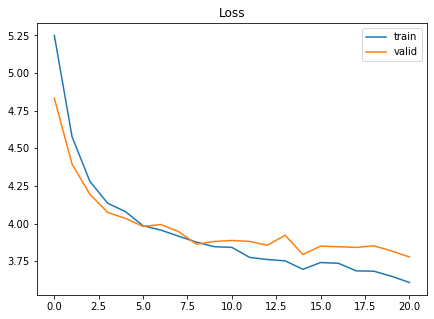

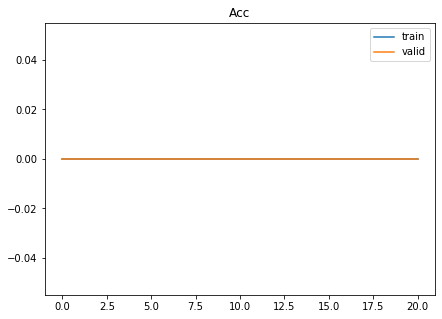

Best F1 score  [0, 20]


In [46]:
with open(MODEL_SAVE_PATH + 'history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_acc = [l['acc'] for l in history['train']]
valid_acc = [l['acc'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('Acc')
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['acc'], idx] for idx, l in enumerate(history['valid'])]))

# %% [markdown]
# ## Test

In [43]:
def parser_words(word_list):
    i = 0
    sentence = ''
    while i < len(word_list):
        if word_list[i] == '<' and i+2 < len(word_list):
            sentence = sentence + word_list[i] + word_list[i+1] + word_list[i+2]
            
            if word_list[i+1] == 'eos':
                break
            else:
                i = i + 3
        else:
            sentence = sentence + word_list[i]
            i = i + 1

        sentence = sentence + ' '

    return sentence


In [44]:
# read datas with only control signal = 10~15
import pickle
file = open('con_sig_dataset_1_n1000.pkl', 'rb')
con_sig_dataset = pickle.load(file)
file.close()

In [45]:
len(con_sig_dataset)

4000

In [46]:
import numpy as np

checkpoint_epoch= 20
model.load_state_dict(torch.load(MODEL_SAVE_PATH + 'model.pkl.{}'.format(checkpoint_epoch)))
model.train(False)

# loadout settings
SAVE_tstep = 1
SAVE_tstep_route = 'evaluate_signal_1/'
SAVE_target = ['decoder.gru.weight_ih_l3',
'decoder.gru.weight_hh_l3',
'decoder.gru.bias_ih_l3',
'decoder.gru.bias_hh_l3']

description = 'Test'
dataset = con_sig_dataset
shuffle = False

dataloader = DataLoader(dataset=dataset,
                        batch_size=len(con_sig_dataset),
                        shuffle=shuffle,
                        collate_fn=dataset.collate_fn,
                        num_workers=4)

trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
test_loss = 0
originals = []
results = []
gts = []
all_corrects = 0
all_queries = 0

for i, (x, x_lengths, y, y_lengths) in trange:
    if i == 2:
        break
    cur_epoch = i
    cur_tstep = 0
    precisions = []
    batch_corrects = 0
    batch_queries = 0
    
    x = x.to(device)
    batch_decoded_indices = model.evaluation(input_vars=x, input_lengths=x_lengths) # batch_size x max_len
    
    if SAVE_tstep == 1:
        output = open(SAVE_tstep_route+'X.'+str(cur_epoch)+'.pkl','wb')
        pickle.dump(x.cpu().numpy(), output)
        output.close()
        
    for sent_idx, decoded_indices in enumerate(batch_decoded_indices):
        
        # Original sentence
        original = []
        input_sentence = x.transpose(0,1)[sent_idx].data.cpu().numpy()
        
        for index in input_sentence:
            original_word = embedder.to_word(index)
            
            if original_word == '<pad>':
                break
                
            original.append(original_word)
            
        #print ('input', input_sentence)
        #print ('input-original', original)
        #print ('input\'s shape', input_sentence.shape)
        
        eos_pos = original.index('<eos>')
        query_pairs = original[eos_pos+1:]
        
        if '<pad>' in query_pairs:
            pad_pos = query_pairs.index('<pad>')
            query_pairs = query_pairs[:pad_pos]
            
        num_query = len(query_pairs) // 2
        
        # Ground truth sentence
        gt = []
        target_sentence = y.transpose(0,1)[sent_idx].data.cpu().numpy()
        
        for _index in target_sentence:   
            gt.append(embedder.to_word(_index))
            
        #print ('target', target_sentence)
        #print ('target-gt', gt)
        #print ('target\'s shape', target_sentence.shape)
        
        # predicted sentence
        decoded_indices = decoded_indices.data.cpu().numpy()
        result = []
        for decoded_index in decoded_indices:
            int_index = int(decoded_index)
            decoded_word = embedder.to_word(int_index)
            result.append(decoded_word)
            
            if decoded_word == '<eos>':
                break
        
        #print ('predicted', decoded_indices)
        #print ('predicted-result', result)
        #print ('predicted\'s shape', decoded_indices.shape)
        
        #print (query_pairs)
        
        for j in range(0, len(query_pairs), 2):
            pos = int(query_pairs[j])
            word = query_pairs[j+1]
            
            if pos < len(result):
                if result[pos] == word:
                    batch_corrects += 1
                
            batch_queries += 1
        
        # print ('input   => %s\npredict => %s\n' % (parser_words(original), parser_words(result)))
        
        results.append(result)
        
        originals.append(original)
        gts.append(gt)
        
    all_corrects = all_corrects + batch_corrects
    all_queries = all_queries + batch_queries
    
    if i % 50 == 0:
        print ('batch', i, '- precision:', batch_corrects / batch_queries)

output = open(SAVE_tstep_route+'results.'+str(cur_epoch)+'.pkl','wb')
pickle.dump(results, output)
output.close()
print ('all - precision:', all_corrects / all_queries)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


batch 0 - precision: 0.9965

all - precision: 0.9965


In [ ]:
print ('all - precision:', all_corrects / all_queries)


In [ ]:
for i in range(10):
    print ('input   => %s\npredict => %s\nground truth => %s\n' % (parser_words(originals[i]), parser_words(results[i]), parser_words(gts[i])))

# %% [markdown]
# ### Write out Output csv file

In [ ]:
original_orderd_results = []

trange = tqdm(enumerate(testData), total=len(testData), desc='Reorder')

for k, (data) in enumerate(trange):
    
    # print ('k:', k)
    test_original = []
    
    for index in testData[k]['Sentence']:
        test_original.append(embedder.to_word(index))

    row_idx = 0
    # print (test_original)
    
    for l, origin in enumerate(originals):
        hit = True
        
        if len(test_original) == len(origin):
            for i in range(len(test_original)):
                if test_original[i] != origin[i]:
                    hit = False
        else:
            hit = False
        
        if hit:
            row_idx = l
            break
    
    if not hit:
        print ('Not found', data)
    # print (originals[k])
    # print (originals[row_idx])
    
    original_orderd_results.append(results[row_idx])


In [ ]:
with open('../hw2.1-1.txt', 'w') as outfile:
    
    trange = tqdm(enumerate(original_orderd_results), total=len(original_orderd_results), desc='WriteBack')
    
    for j, (_row) in enumerate(trange):
        line = parser_words(original_orderd_results[j])
        line = line.strip().upper()
        line = line + '\n'
        outfile.writelines(line)
        
    outfile.close()

